# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [1]:
# Imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = 'data/vehicles.csv'

In [ ]:
!pip install category_encoders

# @title
# Data import
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/AI-ML/BerkeleyHaas/Modules/Module11/practical_application_II_starter/data/vehicles.csv'

In [4]:
vehicles = pd.read_csv(file_path)

In [67]:
vehicles.sample(2)

,price,year,manufacturer,model,condition,odometer,title_status,transmission,drive,size,type,state
301934,23161,2019.0,dodge,charger,excellent,27125.0,clean,automatic,rwd,NaN,sedan,oh
35517,16995,2013.0,mercedes-benz,e-class,NaN,69709.0,clean,automatic,NaN,NaN,sedan,ca


Drop columns which are not required to predict the car price

In [6]:
# drop non important columns
vehicles = vehicles.drop(columns=['id', 'VIN', 'region', 'paint_color', 'cylinders', 'fuel'])
vehicles.sample(1)

,price,year,manufacturer,model,condition,odometer,title_status,transmission,drive,size,type,state
354177,27995,2017.0,nissan,nv2500 hd cargo,NaN,48769.0,clean,automatic,NaN,NaN,NaN,tn


In [7]:
# Check all column datatypes
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   odometer      422480 non-null  float64
 6   title_status  418638 non-null  object 
 7   transmission  424324 non-null  object 
 8   drive         296313 non-null  object 
 9   size          120519 non-null  object 
 10  type          334022 non-null  object 
 11  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 39.1+ MB


In [8]:
# Check how many na values at each column level
vehicles.isna().sum()

,0
price,0
year,1205
manufacturer,17646
model,5277
condition,174104
odometer,4400
title_status,8242
transmission,2556
drive,130567
size,306361


In [9]:
vehicles.describe()

,price,year,odometer
count,4.268800e+05,425675.000000,4.224800e+05
mean,7.519903e+04,2011.235191,9.804333e+04
std,1.218228e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [10]:
vehicles.duplicated().sum()

128259

Data analysis

*   There are lot of columns where data is missing
*   There are cars who's price and odomater readings are 0
*   There are duplicate records present



Drop duplicates

In [11]:
#drop duplicates
vehicles_clean = vehicles.drop_duplicates()
vehicles_clean.shape[0]

298621

Get cars who's price and odometer != 0

In [12]:
#get vehicle data where price and odometer != 0
vehicles_clean = vehicles_clean[~((vehicles_clean['price'].eq(0)) & (vehicles_clean['odometer'].eq(0)))]
vehicles_clean.shape[0]

298285

<Axes: xlabel='state'>

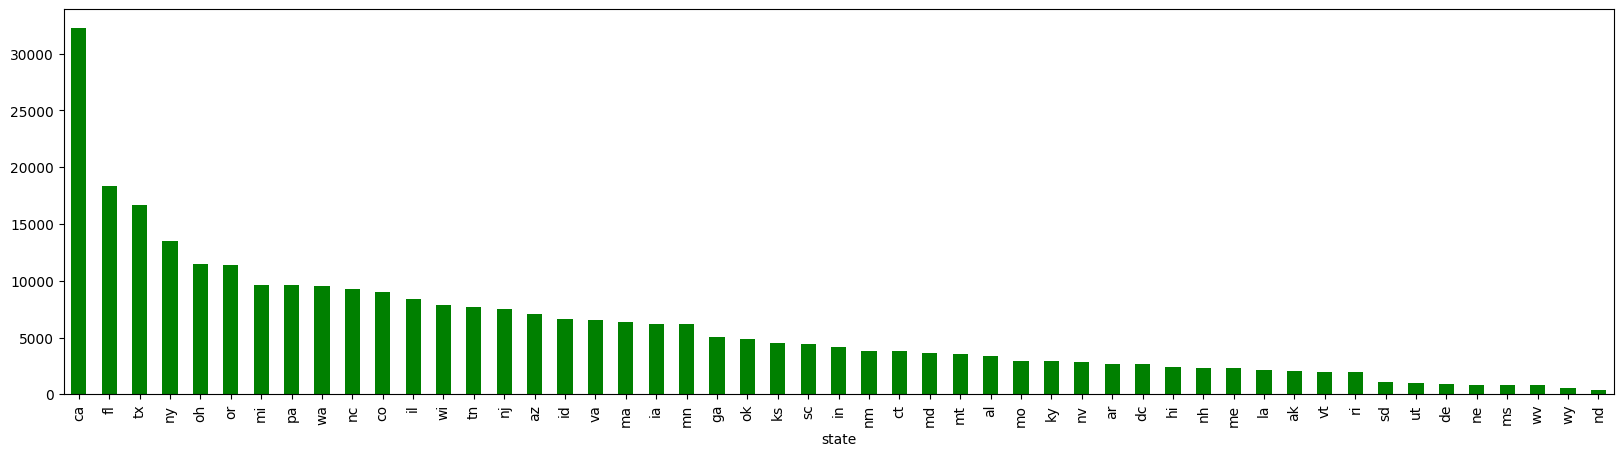

In [13]:
# See data data based on states
plt.figure(figsize=(20,5))
vehicles_clean['state'].value_counts().plot(kind='bar', color='green')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [14]:
# there are so many manufactrers, for this analysis considering top 10
vehicles_group = vehicles_clean.groupby('manufacturer').size().sort_values(ascending=False).head(10).index
filtered_vehicles1 = vehicles_clean[vehicles_clean['manufacturer'].isin(vehicles_group)]

# there are so many models, for this analysis considering top 10
vehicles_group = filtered_vehicles1.groupby('model').size().sort_values(ascending=False).head(10).index
filtered_vehicles = filtered_vehicles1[vehicles_clean['model'].isin(vehicles_group)]

print(filtered_vehicles['manufacturer'].unique())
print(filtered_vehicles['model'].unique())

['chevrolet' 'nissan' 'toyota' 'honda' 'ford' 'ram' 'jeep' 'gmc' 'dodge']
['silverado 1500' 'altima' 'camry' 'accord' 'f-150' 'escape' 'silverado'
 '1500' 'wrangler' 'civic']


In [15]:
# Group data on manufacturer and condition and see which manufacturer has better car conditions
vehicle_grouped_data = filtered_vehicles.groupby(['manufacturer', 'condition']).size().unstack(fill_value=0)
vehicle_grouped_data

condition,excellent,fair,good,like new,new,salvage
manufacturer,,,,,,
chevrolet,1439,156,1088,352,11,9
dodge,0,0,2,0,0,0
ford,1736,157,989,250,9,13
gmc,6,0,5,0,0,0
honda,1112,158,818,258,9,20
jeep,634,37,354,121,2,2
nissan,548,37,334,118,12,11
ram,652,66,415,107,8,6
toyota,643,64,444,128,5,6


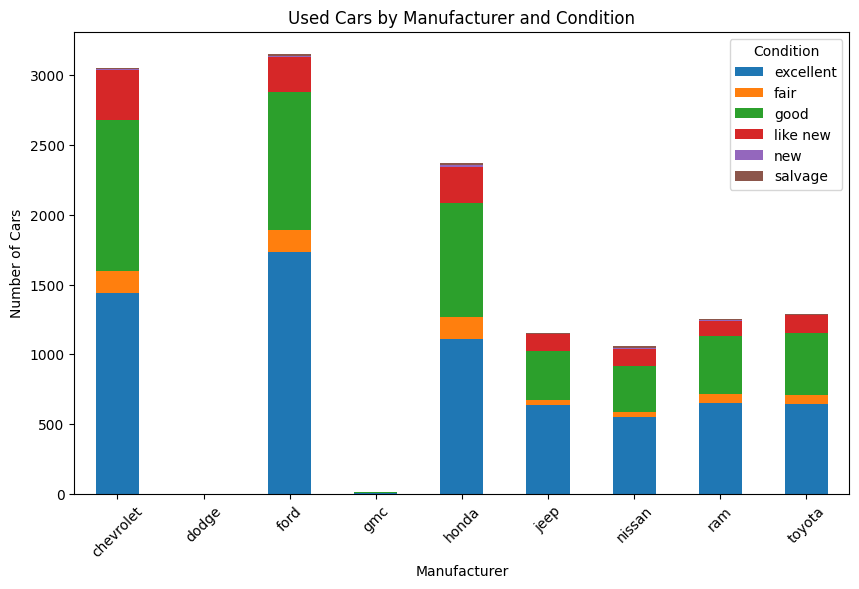

In [16]:
vehicle_grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Used Cars by Manufacturer and Condition')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.show()


**So overall Ford, Chevrolet and Toyota has more cars which are in excellent and good conditions**

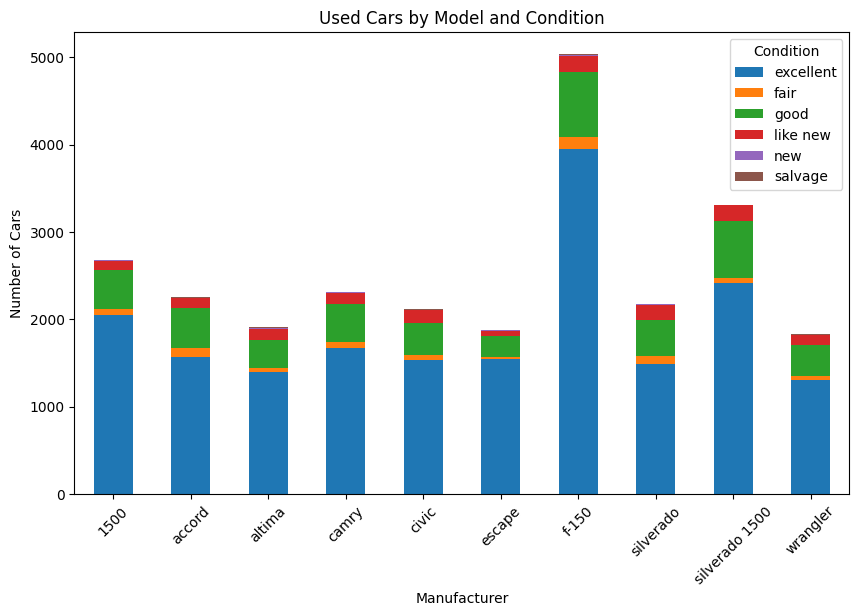

In [56]:
# Group data on model and condition and see which manufacturer has better car conditions
vehicle_grouped_data_model_cond = filtered_vehicles.groupby(['model', 'condition']).size().unstack(fill_value=0)

vehicle_grouped_data_model_cond.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Used Cars by Model and Condition')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.show()

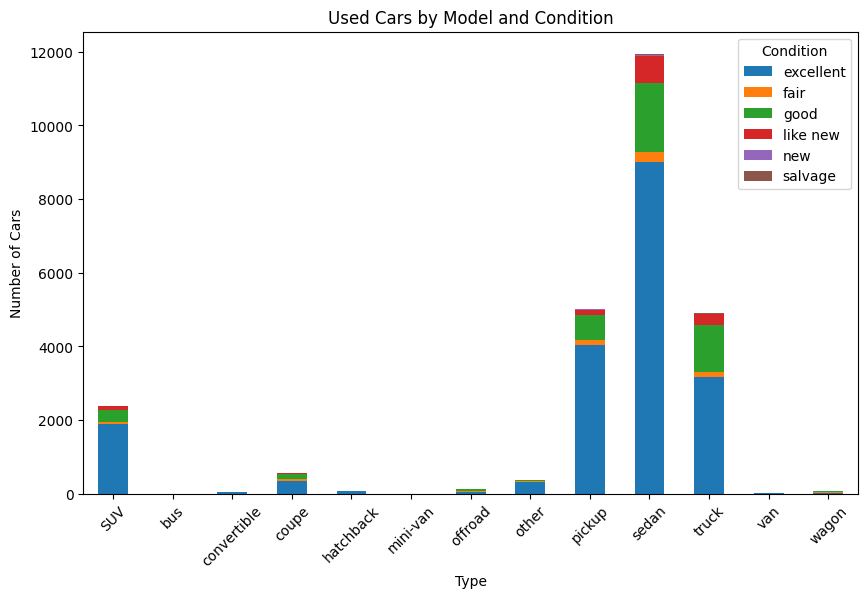

In [57]:
# Group data on type and condition and see which manufacturer has better car conditions
vehicle_grouped_data_type_cond = filtered_vehicles.groupby(['type', 'condition']).size().unstack(fill_value=0)

vehicle_grouped_data_type_cond.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Used Cars by Model and Condition')
plt.xlabel('Type')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

For categorical variables, fill na with mode value

In [17]:
catergorical_cols = ['size', 'type', 'drive', 'title_status', 'condition']
#filtered_vehicles[catergorical_cols] = filtered_vehicles[catergorical_cols].fillna('unknown')
filtered_vehicles[catergorical_cols] = filtered_vehicles[catergorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

Drop rows with na values for any other columns

In [18]:
filtered_vehicles.dropna(inplace=True)

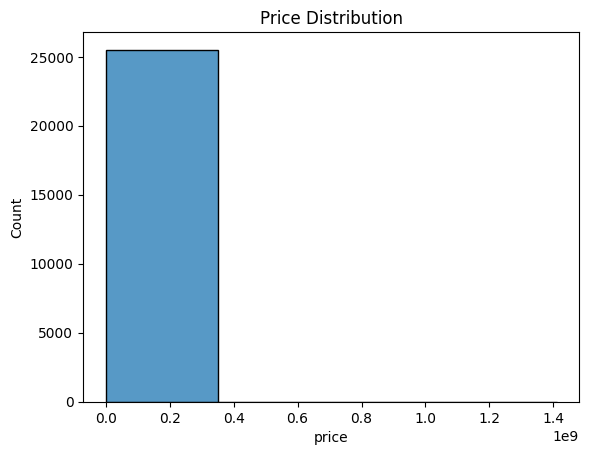

In [19]:
sns.histplot(filtered_vehicles['price'], bins=4, kde=False)
plt.title("Price Distribution")
plt.show()

Apply log value on the price and check the distribution of the price

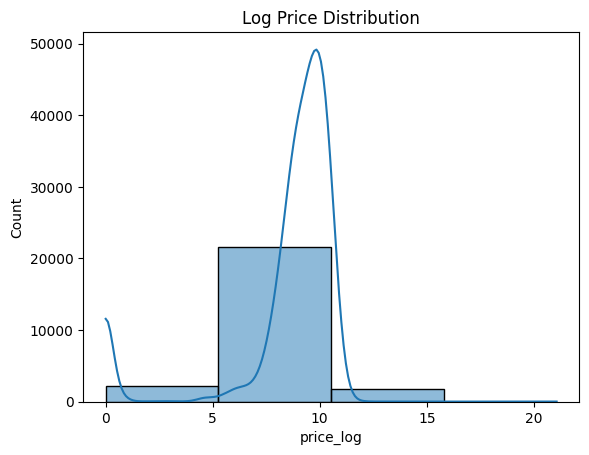

In [20]:
filtered_vehicles['price_log'] = np.log1p(filtered_vehicles['price'])
sns.histplot(filtered_vehicles['price_log'], bins=4, kde=True)  # Kernel Density Estimate (KDE) for smooth curve
plt.title("Log Price Distribution")
plt.show()

Remove price outliers using IQR

In [21]:
Q1 = filtered_vehicles['price_log'].quantile(0.25)
Q3 = filtered_vehicles['price_log'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# vehicles_data withour price outliers
vehicles_data = filtered_vehicles[(filtered_vehicles['price_log'] > lower_bound) & (filtered_vehicles['price_log'] < upper_bound)]
vehicles_data.shape[0]

print(lower_bound)
print(upper_bound)

print(filtered_vehicles.shape[0])
print(vehicles_data.shape[0])

6.248981538573539
12.284715127494806
25514
23051


Check odometer outliers

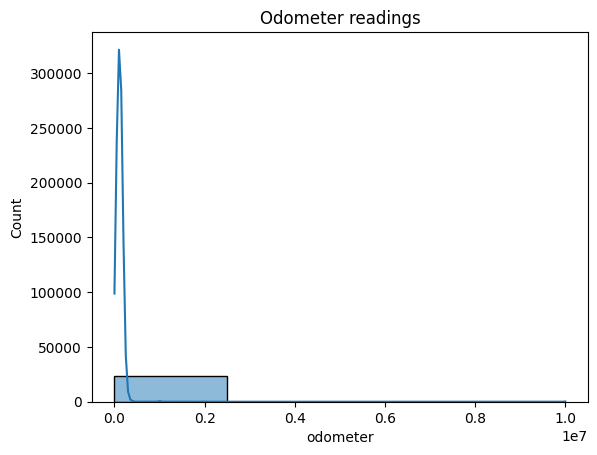

In [22]:
# Check odometer outliers
sns.histplot(vehicles_data['odometer'], bins=4, kde=True)  # Kernel Density Estimate (KDE) for smooth curve
plt.title("Odometer readings")
plt.show()

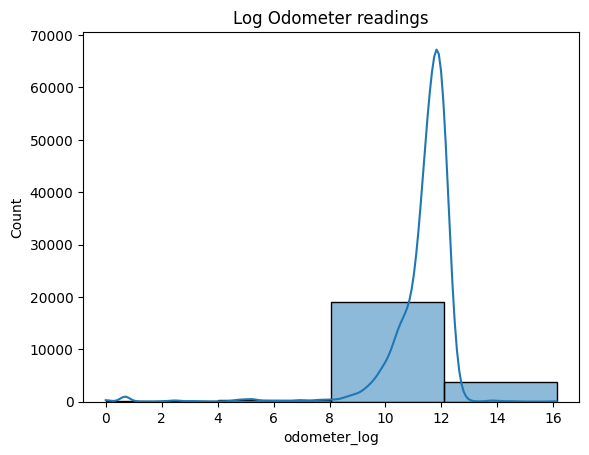

In [23]:
vehicles_data['odometer_log'] = np.log1p(vehicles_data['odometer'])
sns.histplot(vehicles_data['odometer_log'], bins=4, kde=True)  # Kernel Density Estimate (KDE) for smooth curve
plt.title("Log Odometer readings")
plt.show()

In [24]:
Q1 = vehicles_data['odometer_log'].quantile(0.25)
Q3 = vehicles_data['odometer_log'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# vehicles_data withour price outliers
vehicles_data = vehicles_data[(vehicles_data['odometer_log'] > lower_bound) & (vehicles_data['odometer_log'] < upper_bound)]
vehicles_data.shape[0]

print(lower_bound)
print(upper_bound)

print(vehicles_data.shape[0])

9.86617851735296
13.213219490381451
21670


Drop log columns for price and odometer

In [25]:
vehicles_data.drop('price_log', axis=1, inplace=True)
vehicles_data.drop('odometer_log', axis=1, inplace=True)

In [26]:
vehicles_data.sample(2)

,price,year,manufacturer,model,condition,odometer,title_status,transmission,drive,size,type,state
25694,19999,2009.0,chevrolet,silverado 1500,excellent,117758.0,clean,automatic,4wd,full-size,truck,ca
171310,6000,1996.0,ram,1500,good,145000.0,clean,automatic,4wd,full-size,truck,ky


In [27]:
# Lets consider car manufacture year after 1999
vehicles_data = vehicles_data[vehicles_data['year'] > 1999]

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [28]:
vehicles_data_copy = vehicles_data.copy()

In [29]:
for col in ['condition', 'title_status', 'transmission', 'drive', 'size', 'type', 'state', 'manufacturer', 'model']:
    vehicles_data_copy[col] = vehicles_data_copy[col].astype('category')  # Convert to categorical
    vehicles_data_copy[col] = vehicles_data_copy[col].cat.codes  # Replace with numerical codes


In [30]:
X = vehicles_data_copy.drop(['price'], axis=1)
y = vehicles_data_copy['price']

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [31]:
# Evaluate using Linear Regression model
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Now predict the price
y_pred = model.predict(X_test)

# Now evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error: ', mse)
print('R2 Score: ', r2)

Mean Squared Error:  45169184.38793192
R2 Score:  0.6826602390442831


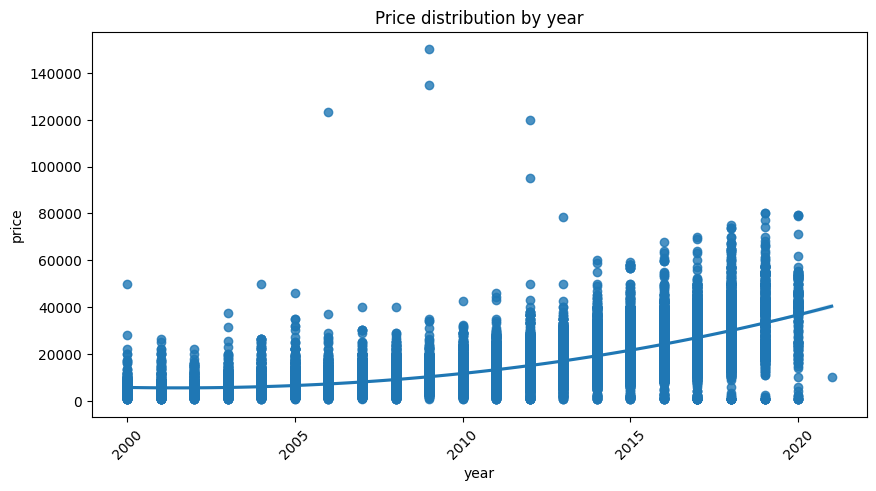

In [32]:
# plot the polynomial regression model
plt.figure(figsize=(10, 5))
sns.regplot(x='year', y='price', data=vehicles_data_copy, order=3)
plt.title('Price distribution by year')
x = plt.xticks(rotation=45)
plt.show()

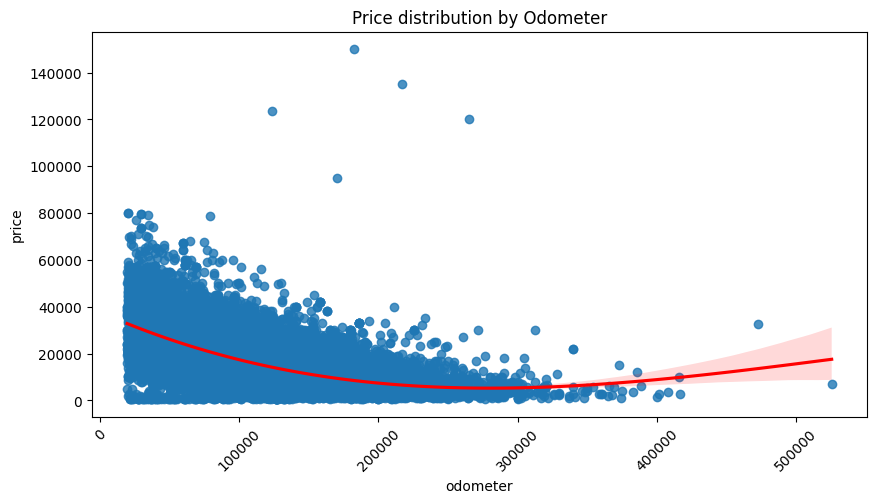

In [51]:
# plot the polynomial regression model
plt.figure(figsize=(10, 5))
sns.regplot(x='odometer', y='price', data=vehicles_data_copy, order=3, line_kws={"color": "red"})
plt.title('Price distribution by Odometer')
x = plt.xticks(rotation=45)
plt.show()

In [41]:
vehicles_data_copy = vehicles_data.copy()

In [42]:
vehicles_data_one_hot = pd.get_dummies(vehicles_data_copy, columns=['condition', 'title_status', 'transmission', 'drive', 'type', 'state', 'size', 'manufacturer', 'model'])

vehicles_data_one_hot.sample(2)

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,title_status_clean,...,model_1500,model_accord,model_altima,model_camry,model_civic,model_escape,model_f-150,model_silverado,model_silverado 1500,model_wrangler
322976,5995,2007.0,167123.0,False,False,True,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
210648,34500,2014.0,64805.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [44]:
from sklearn.decomposition import PCA
from scipy.linalg import svd

vehicles_data_scaled = (vehicles_data_one_hot - vehicles_data_one_hot.mean())/vehicles_data_one_hot.std()

#Preparation for PCA
U, sigma, VT = svd(vehicles_data_scaled, full_matrices=False)
percent_variance_explained = sigma/sigma.sum()
cumulative_variance_ratio = np.cumsum(sigma)/sigma.sum()

#Identify number of components needed to achieve at least 80% variance
num_of_components_over_80pct_variance = int((np.cumsum(percent_variance_explained) < .8).sum())
print(f"Number of components needed to achieve at least 80% variance: {num_of_components_over_80pct_variance}")

Number of components needed to achieve at least 80% variance: 69


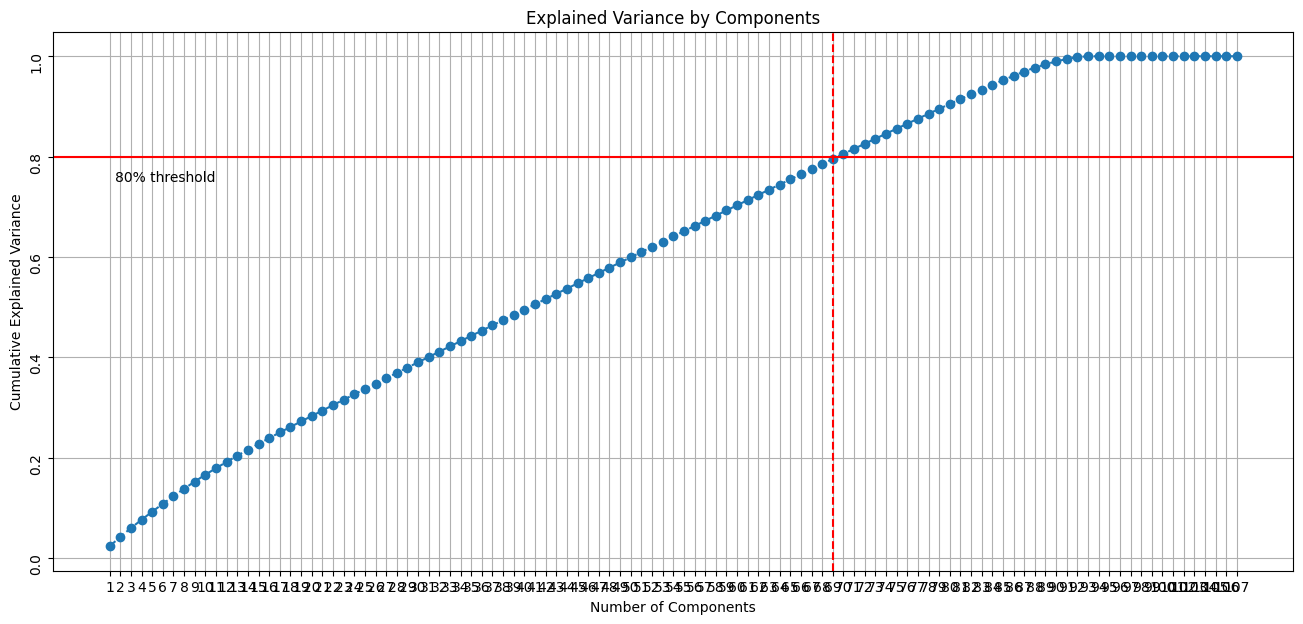

In [36]:
# Plot the explained variance
plt.figure(figsize=(16, 7))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.75, '80% threshold')
plt.axvline(x=num_of_components_over_80pct_variance-1, color='r', linestyle='--')
plt.xticks(np.arange(len(cumulative_variance_ratio)), np.arange(1, len(cumulative_variance_ratio)+1))
plt.yticks(rotation=90)
plt.grid(True)

plt.show()

In [37]:
#Extracting the Components
pca = PCA(n_components = num_of_components_over_80pct_variance)
pca.fit(vehicles_data_scaled)
components = pca.transform(vehicles_data_scaled)

# The loadings are the components_ attribute of the PCA object, but these need to be scaled by the square root of the eigenvalues (explained_variance_)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame of loadings with rows corresponding to features and columns to components
loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=vehicles_data_scaled.columns)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
price,-0.630371,-0.000171,0.324990,-0.309796,0.199535,-0.176718,-0.105003,-0.141720,-0.121229,-0.243296,...,-0.000780,-0.023597,-0.021042,0.002125,0.021230,0.028435,-0.026114,0.004501,0.005057,0.000520
year,-0.305869,-0.107731,0.594100,-0.329296,0.195398,-0.151105,0.037699,-0.152742,-0.182801,-0.162025,...,-0.018627,-0.007497,-0.000228,0.007388,0.013990,0.036177,-0.012222,0.027314,0.011751,-0.003508
odometer,0.183095,-0.044695,-0.556165,0.380264,-0.192712,0.130892,0.016065,0.181267,0.175234,0.197186,...,0.023969,-0.000581,-0.024889,0.000196,-0.026710,-0.029433,0.033213,-0.014217,-0.008596,0.005794
condition_excellent,-0.171591,0.007602,0.525218,-0.256354,0.152450,-0.262714,-0.209228,0.065226,0.337678,0.210484,...,0.000366,0.016715,-0.022364,-0.018054,-0.045521,-0.053464,-0.026370,-0.019218,0.045569,-0.034983
condition_fair,0.086874,-0.004108,-0.211860,0.154986,-0.036833,0.093363,0.053458,-0.002499,-0.025455,0.017014,...,0.043761,-0.032266,0.057071,-0.064403,-0.142982,0.093661,0.076976,0.082443,0.075364,-0.056398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
model_escape,-0.021925,0.211180,0.351936,0.435928,-0.103045,0.012728,0.086002,-0.032276,-0.327893,0.392473,...,-0.014853,-0.036651,0.030453,-0.040621,-0.044593,0.016692,0.015551,-0.027669,-0.028166,-0.012247
model_f-150,-0.394868,-0.080736,0.282208,0.536217,0.037663,0.106738,0.110971,-0.023925,0.381632,-0.418655,...,-0.015506,0.010366,-0.029537,0.007783,0.037590,-0.008911,-0.007875,0.009289,0.018211,0.008789
model_silverado,-0.198039,-0.152521,-0.333048,-0.069511,-0.076518,-0.325662,0.025096,-0.058161,-0.050040,0.142010,...,0.004283,-0.055584,-0.113782,-0.022744,0.049699,0.026507,0.020893,-0.039094,-0.100336,-0.048644
model_silverado 1500,-0.314857,-0.192002,-0.369541,-0.156259,-0.051080,-0.458596,0.006214,-0.053135,-0.213800,-0.025479,...,-0.016241,0.028793,0.088331,0.025530,-0.046393,-0.019770,-0.026018,0.038271,0.068691,0.028527


In [38]:
# Sort the features with the highest loadings for each component
sorted_indices = {f'PC{i+1}': loading_matrix[f'PC{i+1}'].abs().sort_values(ascending=False).index
                  for i in range(loading_matrix.shape[1])}

#select the top 3 features for each component
loading_matrix_sorted_all = pd.DataFrame(sorted_indices)
loading_matrix_sorted_all = loading_matrix_sorted_all[:3]

loading_matrix_sorted_all

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
0,drive_fwd,model_wrangler,year,manufacturer_ford,manufacturer_honda,manufacturer_ram,model_altima,title_status_clean,size_full-size,transmission_automatic,...,state_de,state_nv,state_ri,state_nd,type_mini-van,type_van,type_hatchback,state_dc,type_mini-van,manufacturer_dodge
1,type_sedan,manufacturer_jeep,odometer,model_f-150,model_camry,model_1500,manufacturer_nissan,title_status_rebuilt,size_mid-size,model_f-150,...,state_nd,state_la,state_wy,state_ut,state_wv,manufacturer_dodge,state_md,condition_new,state_nh,type_mini-van
2,drive_4wd,transmission_automatic,manufacturer_chevrolet,model_escape,manufacturer_toyota,manufacturer_chevrolet,manufacturer_toyota,title_status_salvage,model_f-150,model_escape,...,state_ne,state_in,state_sd,state_sd,state_ms,title_status_parts only,state_ut,state_nd,state_mn,state_ky


In [39]:
# lets build a regression model using the PCA components
X = components
y = vehicles_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# lets predict the price
y_pred = model.predict(X_test)

# lets evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print('Mean Squared Error: ', mse)

print('R2 Score: ', r2)

Mean Squared Error:  25455480.57839436
R2 Score:  0.821572448303045


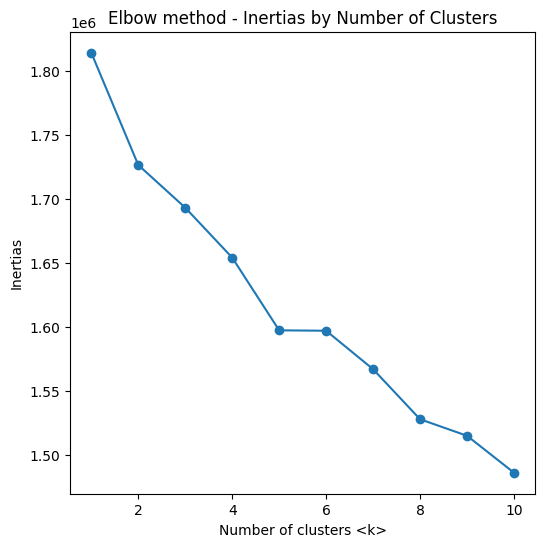

In [40]:
from sklearn.cluster import KMeans, DBSCAN

#Identify the inertias for different number of clusters
inertias = []
for i in range(1, 11): # 1 to 10 clusters
    kmeans = KMeans(n_clusters = i, n_init='auto').fit(components)
    inertias.append(kmeans.inertia_)

#Plot the inertias for different number of clusters to identify the elbow
plt.figure(figsize=(6, 6))
plt.plot(range(1,11), inertias, '-o')
plt.xlabel('Number of clusters <k>')
plt.ylabel('Inertias')
plt.title('Elbow method - Inertias by Number of Clusters')
plt.show()

As per the findings, below features influence the price of the cars:


1. Year - More recent cars have a higher value compared tothe older once
2. Odometer: It has negative correlation with price. More than odometer value, lesser the price
3. Type of the car: Sedan cars  are most popular cars
4. Drive mode: FWD and the 4WD are the most popular drive mode cars
5. Manufacturer: Jeep and Chevrolet has more demand